In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [8]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [9]:
#@hidden_cell

%pylab inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import quandl
import bt


import monthly_returns_heatmap as mrh
figsize(3,3)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys,os
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage


import pandas as pd
import numpy as np
import scipy
import pprint



In [11]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

In [12]:
storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)

In [13]:
swm_info = storage.swarms_info()
pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(swm_info)

In [14]:
product_name = '*'

In [15]:
#instruments_filter = [product_name]  # Select ALL
instruments_filter = ['*']

#exo_filter = ['CL_'] # Select ALL
exo_filter = ['*']

direction_filter = [0, -1, 1] # Select ALL
#direction_filter = [1]

# alpha_filter = ['March_30_2018','EXO']  # Select ALL
alpha_filter = ['May_7','*']
#alpha_filter = ['_AlphaV1Exposure_HedgedBy_V2_Index','Aug','Sept']
#alpha_filter = ['CL_ContFut']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)

/var/data/tmqrengine/exobuilder/data/exostorage.py:154: UserWarning: Failed to load new framework alphas: 'equity'
  warnings.warn("Failed to load new framework alphas: {0}".format(exc))


In [16]:
# [print("'{}',".format(s)) for s in sorted(swmdf.columns)];

In [17]:
campaign_exposure = {
    

    
'CL_ContFut_Long_EXO' : 0.5,  
'CL_ContFut_Short_EXO': 1.9,  

    
'CL_ContFut_Long_Strategy_DSP_LowPass__Bullish_2_Dec_18_custom': 2.0,
'CL_ContFut_Long_Strategy_DSP_LowPass__Bullish_Dec_11_custom': 2.0,
'CL_ContFut_Long_Strategy_DSP_LPBP_Combination__Bullish_1_March_30_2018_custom': 2.0,
    

'CL_ContFut_Short_Strategy_DSP_LPBP_Combination__Bearish_2_March_30_2018_custom': 2.0,
'CL_ContFut_Short_Strategy_DSP_LPBP_Combination__Bearish_2_Dec_19_custom': 2.0,
'CL_ContFut_Short_Strategy_DSP_LowPass__Bearish_Dec_18_custom': 2.0, 


    
}

In [18]:
campaign_dict = {}
campaign_stats = {'NetProfit': 0.0, 'TradesCount': 0, 'CommissionSum': 0.0}
campaign_deltas_dict = {}

for camp_name, exposure in campaign_exposure.items():
    if camp_name in swmdf:
        swarm_name = camp_name
        campaign_dict[swarm_name] = swmdf[swarm_name] * exposure
        
        # TODO: implement swarm statistics
        for s in swm_data:            
            if s['swarm_name'] != swarm_name:
                continue
            series = s['swarm_series']
            
            
            _delta_arr = campaign_deltas_dict.setdefault('', pd.Series(0, index=series['delta'].index))                                    
            campaign_deltas_dict[''] = pd.concat([_delta_arr, series['delta']*exposure], axis=1).sum(axis=1)
    
campaign_portfolio = pd.DataFrame(campaign_dict).ffill()
campaign_equity = campaign_portfolio.sum(axis=1)
campaign_deltas = pd.DataFrame(campaign_deltas_dict)
# print(campaign_deltas.tail())
# print(campaign_deltas.abs().max())
print('current Ursus CL futures holdings' + str(campaign_deltas.tail(2)))


total = campaign_portfolio.sum(axis=1)
total = pd.DataFrame(total)
total.columns = [ 'Futures_replication'] #change to the campaign
total.index.name = 'date'

print('Estimated Ursus CL futures PnL' + str(total.diff().tail(3)  ))

total.diff().tail()

Ursus_Crude_Oil = total

current Ursus CL futures holdings               
2018-09-11  0.6
2018-09-12  0.6
Estimated Ursus CL futures PnL            Futures_replication
date                           
2018-09-11              -9954.0
2018-09-12                684.0
2018-09-13                  0.0


In [19]:
capital = abs(campaign_deltas).max().mul(5).mul(5000)
capital = int(capital)

### Campaign members equities

In [20]:
import bt
import ffn

total = total + capital
total = total.asfreq('D', method='ffill').dropna() 

long_sma  = total.rolling(window=210,center=False).median()

#     # target weights
tw = long_sma.copy()
tw[total > long_sma] = 2.0
tw[total <= long_sma] = 1.00
tw[long_sma.isnull()] = 0.0

    ##here we specify the children (3rd) arguemnt to make sure the strategy
   ## has the proper universe. This is necessary in strategies of strategies
Buy_and_Hold_CL_S = bt.Strategy('Ursus Crude Oil Index', 
                                          [bt.algos.WeighTarget(tw),
                                           bt.algos.RunWeekly(),
                                           bt.algos.Rebalance()])




# Buy_and_Hold_ES_L = bt.Strategy('Long CL_L', 
#                       [bt.algos.RunMonthly(),
#                        bt.algos.SelectAll(),
#                        bt.algos.WeighEqually(),
#                        bt.algos.Rebalance()])

# cl_LS_alpha_portfolio = bt.Backtest(Buy_and_Hold_cl_LS, cl_LS)
CL_S_alpha_portfolio = bt.Backtest(Buy_and_Hold_CL_S, total,
#             initial_capital=150000.0, 
            commissions=lambda q, p: max(10, abs(q) * 0.0021),
            integer_positions=True, 
            progress_bar=True)


res_CL_S = bt.run(CL_S_alpha_portfolio)

Ursus Crude Oil Index
0% [############################# ] 100% | ETA: 00:00:00

In [21]:
try:
    sco_BM = bt.get('sco', start='2012-01-01')
except:
    pass

In [22]:
s_BM = bt.Strategy('Short_Crude_Oil_BM (SCO)', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

test_BM = bt.Backtest(s_BM, sco_BM)

r = bt.run(CL_S_alpha_portfolio, test_BM)

Short_Crude_Oil_BM (SCO)
0% [############################# ] 100% | ETA: 00:00:00

In [23]:
data_EW  = res_CL_S.prices

returns = pd.DataFrame(data_EW) 
# .asfreq('BM').tail(1400)
returns.index = pd.to_datetime(returns.index)
returns.columns = ['Ursus Crude Oil Index']
# returns = returns.add()

# Ursus Crude Oil Index

/home/tmqr_framework2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


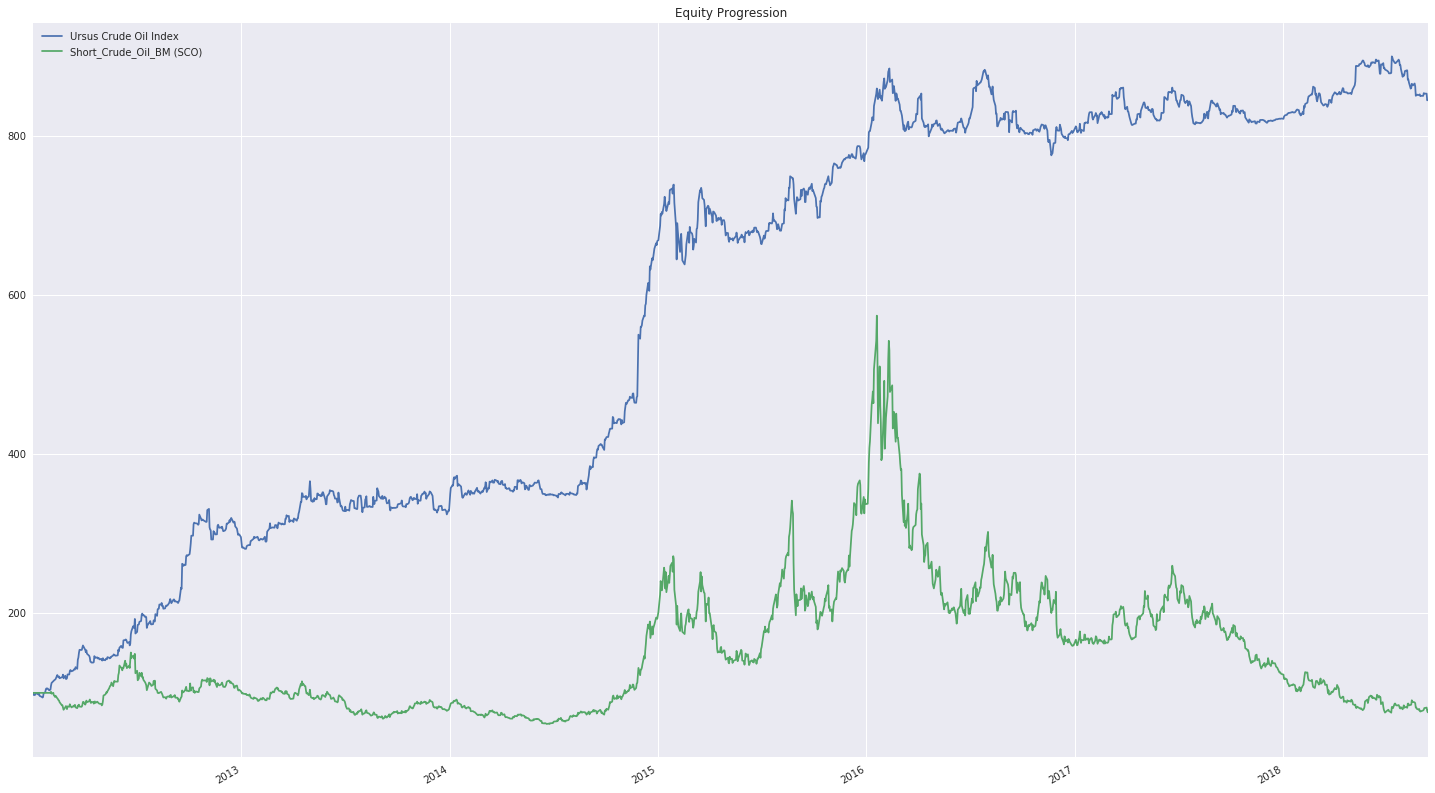

In [29]:
# res_CL_S.plot()

r.plot(figsize=(25, 15))
# r.plot()

/home/tmqr_framework2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


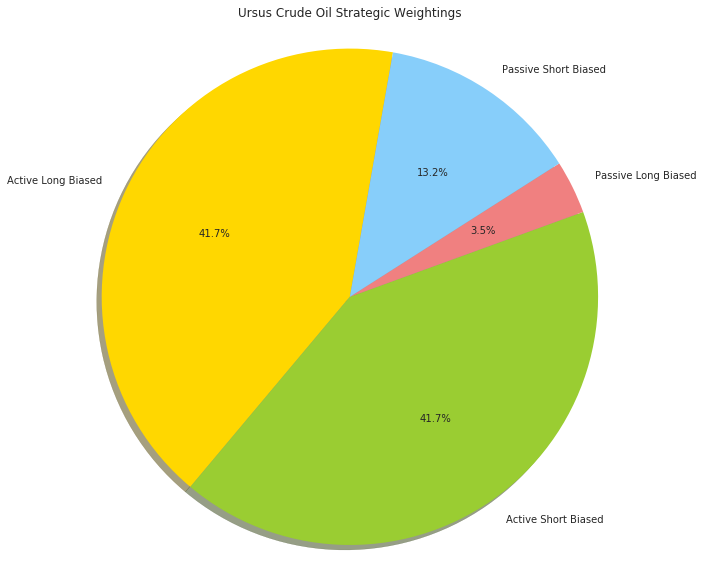

In [25]:
# Data to plot
figsize(10,10)
labels = ['Active Long Biased','Active Short Biased', 'Passive Long Biased', 'Passive Short Biased']
sizes = [6.0, 6.0, 0.5, 1.9]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=80)
 
plt.axis('equal')
plt.title('Ursus Crude Oil Strategic Weightings',)
plt.show()

/home/tmqr_framework2/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


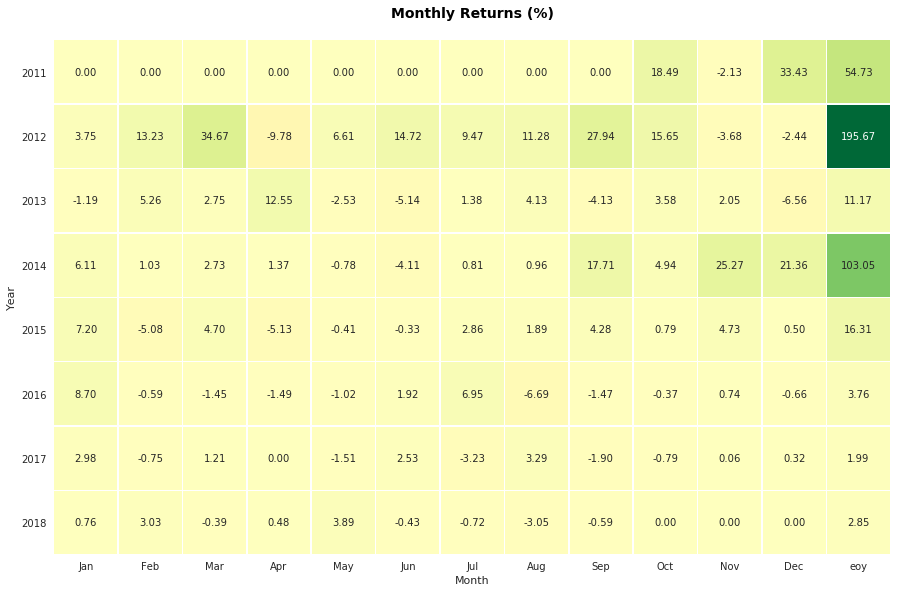

In [26]:
returns.plot_returns_heatmap(is_prices=True,eoy=True,figsize=(15,20),cbar=False, cmap='RdYlGn',square=True)

In [27]:
r.display()

Stat                 Ursus Crude Oil Index    Short_Crude_Oil_BM (SCO)
-------------------  -----------------------  --------------------------
Start                2012-01-02               2012-01-02
End                  2018-09-13               2018-09-13
Risk-free rate       0.00%                    0.00%

Total Return         744.83%                  -21.26%
Daily Sharpe         1.61                     0.24
Daily Sortino        2.45                     0.34
CAGR                 37.53%                   -3.51%
Max Drawdown         -15.17%                  -86.91%
Calmar Ratio         2.47                     -0.04

MTD                  -0.59%                   2.43%
3m                   -5.65%                   -14.04%
6m                   0.85%                    -32.16%
YTD                  2.85%                    -36.44%
1Y                   1.42%                    -57.00%
3Y (ann.)            4.83%                    -30.49%
5Y (ann.)            20.11%                   2.65%

In [28]:
r.display_lookback_returns()

,Short_Crude_Oil_BM (SCO),Ursus Crude Oil Index
mtd,2.43%,-0.59%
3m,-14.04%,-5.65%
6m,-32.16%,0.85%
ytd,-36.44%,2.85%
1y,-57.00%,1.42%
3y,-30.49%,4.83%
5y,2.65%,20.11%
10y,-3.51%,37.53%
incep,-3.51%,37.53%
